# Bias quantification using fuzzy-rough sets

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")
#import skfuzzy as fuzz
import matplotlib.pyplot as plt
from numpy import linalg as la
from sklearn import preprocessing
from scipy.spatial import distance

Step1. Load the data to be processed as a CSV file. The expected file should not have a header, the values should be normalized for better performance, the decision attribute should be in the last column, and the decision classes should be encoded as integers starting at zero.

In [ ]:
# German
df = pd.read_csv("german_data_normalized.csv", na_values='?', header=None)
protected = [False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False]
numeric = [False, True, False, False, True, False, False, True, False, False, True, False, True, False, False, True, False, True, False, False]
nominal = list(np.where(np.array(numeric) == True, False, True))
Z = df.values

Step2. Compute the fuzzy-rough approximations. These memberships values are the input to the fuzzy-rough set bias quantification measure.

In [ ]:
class FRS:

    def __init__(self, dataset, att):
        self.X = dataset
        self.p_att = att
        self.D = None

    def regions(self):
        
        self.D = np.unique(self.X[:,-1])

        POS = np.zeros((len(self.D), len(self.X)))
        NEG = np.zeros((len(self.D), len(self.X)))
        BND = np.zeros((len(self.D), len(self.X)))

        for k in range(len(self.D)):
            for idx in range(len(self.X)):
                POS[k][idx], NEG[k][idx], BND[k][idx] = self.process_object(idx, k)

        return POS, NEG, BND

    def process_object(self, idx, k):

        inf = 1
        sup = 0

        x = self.X[idx,:]
        
        for y in self.X:
            inf = min(inf, self.implicator(self.fuzzy_relation(x, y, k), self.membership(y, k)))
            sup = max(sup, self.conjunction(self.fuzzy_relation(y, x, k), self.membership(y, k)))

        inf = min(inf, self.membership(x, k))
        sup = max(sup, self.membership(x, k))

        return inf, 1-sup, sup-inf

    def similarity(self, x, y):
        
        distance = 0
        for i in range(len(x)-1):
            
            if self.p_att == i:
                continue
            
            if numeric[i]:
                distance += abs(x[i] - y[i])
            else:
                distance += 1.0 if (x[i] != y[i]) else 0.0
        
        return np.exp(-0.5 * distance)

    def implicator(self, a, b):
        return min(1 - a + b, 1)

    def conjunction(self, a, b):
        return max(a + b - 1, 0)

    def fuzzy_relation(self, x, y, k):
        return self.membership(x, k) * self.similarity(x, y)

    def membership(self, x, k):
        return 1.0 if x[-1] == k else 0.0

Next, we compute the regions without excluding any feature (denoted by the index -1)

In [ ]:
POS_full, NEG_full, BND_full = FRS(Z, -1).regions()

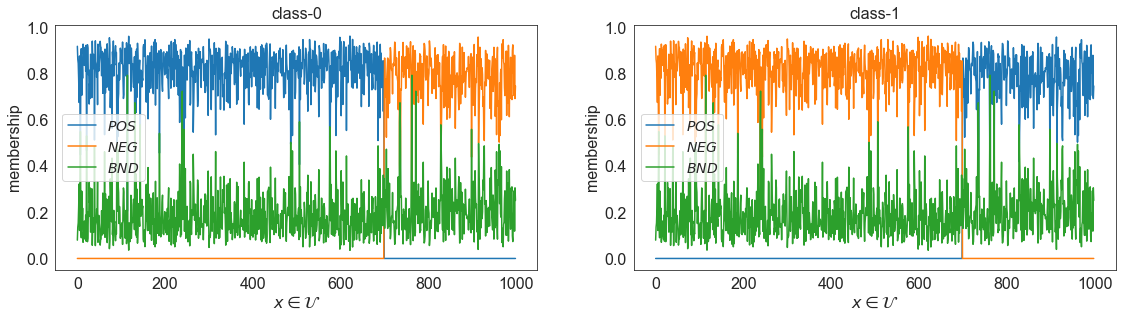

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(19, 4.5))

for i in range(len(POS_full)):
    
    ax = axes.reshape(-1)[i]
    ax.set_xlabel('$x \in \mathcal{U}$', fontsize=16)
    ax.set_ylabel('membership', fontsize=16)
    ax.set_title('class-' + str(i), fontsize=16)
    
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.plot(POS_full[i])
    ax.plot(NEG_full[i])
    ax.plot(BND_full[i])
    
    ax.legend(["$POS$", "$NEG$", "$BND$"], fontsize=14)

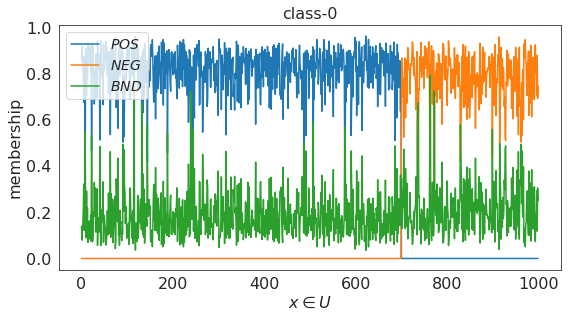

In [ ]:
plt.figure(figsize=(9, 4.5))
plt.plot(POS_full[0])
plt.plot(NEG_full[0])
plt.plot(BND_full[0])
plt.xlabel('$x \in U$', fontsize=16)
plt.ylabel('membership', fontsize=16)
plt.title('class-' + str(0), fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(["$POS$", "$NEG$", "$BND$"], fontsize=14, loc = 'upper left')
plt.savefig('regions-class-0.pdf')

plt.show()

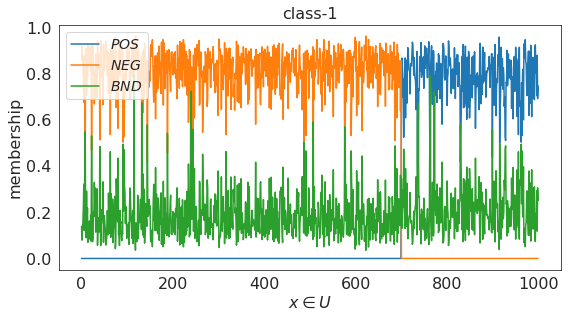

In [ ]:
plt.figure(figsize=(9, 4.5))
plt.plot(POS_full[1])
plt.plot(NEG_full[1])
plt.plot(BND_full[1])
plt.xlabel('$x \in U$', fontsize=16)
plt.ylabel('membership', fontsize=16)
plt.title('class-' + str(1), fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(["$POS$", "$NEG$", "$BND$"], fontsize=14, loc = 'upper left')
plt.savefig('regions-class-1.pdf')

plt.show()

Next, we compute the regions excluding gender (index=8) and age (index=12)

In [ ]:
POS_9, NEG_9, BND_9 = FRS(Z, 8).regions()
POS_13, NEG_13, BND_13 = FRS(Z, 12).regions()

Our proposed global bias quantification measure can be understood as the difference between the resulting boundary regions. If the difference is positive, we can conclude that the boundary regions became bigger after removing the protected attribute, so there is more uncertainty (the attribute is important for the classification). If the difference is negative, we can conclude that the boundary regions became smaller after removing the protected attribute, so there is less uncertainty (the attribute was causing more uncertainty since it was not that important).

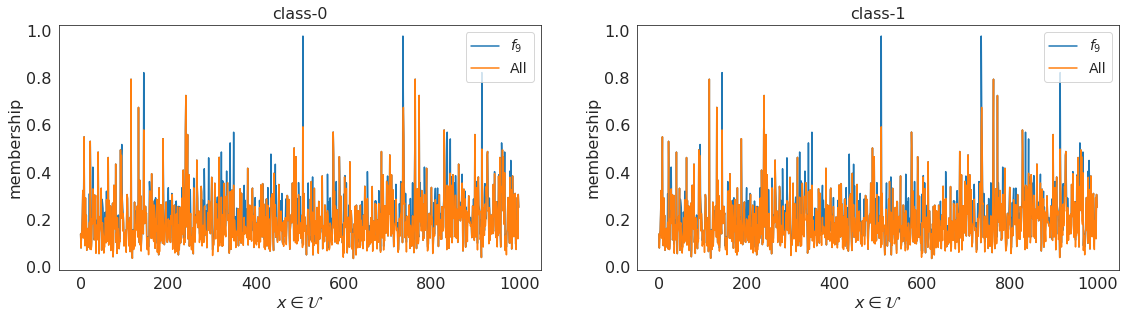

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(19, 4.5))

for i in range(2):

    ax = axes.reshape(-1)[i]
    ax.set_xlabel('$x \in \mathcal{U}$', fontsize=16)
    ax.set_ylabel('membership', fontsize=16)
    ax.set_title('class-' + str(i), fontsize=16)
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.plot(BND_9[i])
    ax.plot(BND_full[i])
    
    ax.legend(["$f_9$", "All"], fontsize=14)
    plt.savefig('gender_fru.png')

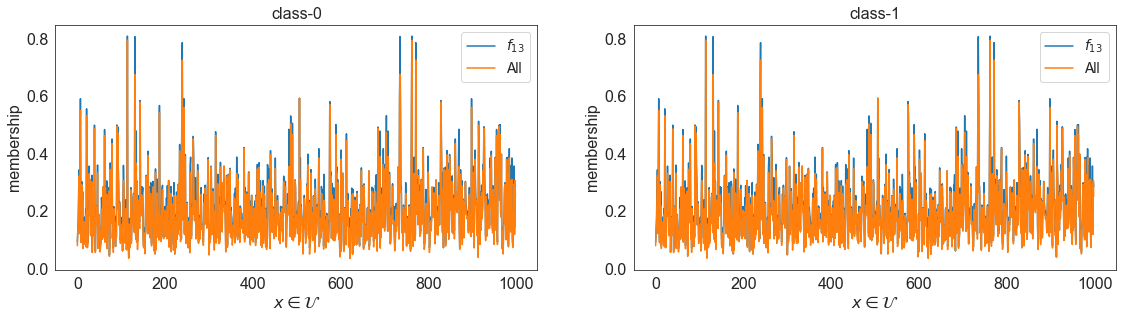

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(19, 4.5))

for i in range(2):
    
    ax = axes.reshape(-1)[i]
    ax.set_xlabel('$x \in \mathcal{U}$', fontsize=16)
    ax.set_ylabel('membership', fontsize=16)
    ax.set_title('class-' + str(i), fontsize=16)
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.plot(BND_13[i])
    ax.plot(BND_full[i])
    
    plt.savefig('parameters.png')
    ax.legend(["$f_{13}$", "All"], fontsize=14)

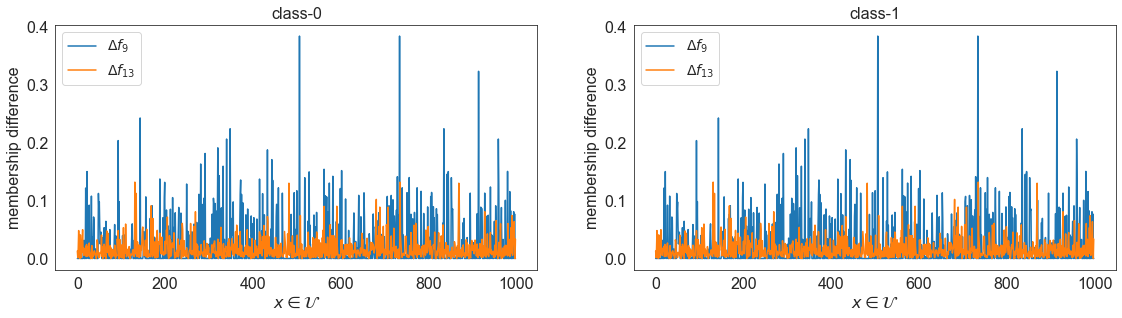

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(19, 4.5))

for i in range(1):
    
    ax = axes.reshape(-1)[i]
    ax.set_xlabel('$x \in \mathcal{U}$', fontsize=16)
    ax.set_ylabel('membership difference', fontsize=16)
    ax.set_title('class-' + str(i), fontsize=16)
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.plot(BND_9[i] - BND_full[i])
    ax.plot(BND_13[i] - BND_full[i])
    
    ax.legend(["$\Delta f_9$", "$\Delta f_{13}$"], fontsize=14)
    

Let us quantify these differences. Recall that we are only interested in positive differences (instances for which the uncertainty increased when compared with the membership values to the boundary regions). Formally, the normalized change measure for a protected attribute is given by:

$\Omega_k(\neg f_i) =  \sqrt{ \sum_{x \in \mathcal{U}} \Big( \Delta_{B_k \neg f_i}^+(x) \Big)^2} / \sqrt{ \sum_{x \in \mathcal{U}} \Big( \mu_{B_k}(x) \Big)^2}$ 

such that $\Delta_{B_k \neg f_i}^+(x) = \mu_{B_k}(x) - \mu_{B_k \neg f_i}(x)$ when the removal of the $f_i$ feature increased the uncertainty. Otherwise, we will assume that $\Delta_{B_k \neg f_i}^+(x) = 0$, which means that the uncertainty attached to that instance did not increase after supressing the protected feature.

In [ ]:
diff_9 = BND_9[0] - BND_full[0]
diff_9 = np.where(diff_9 < 0, 0, diff_9)
print("change(gender) = " + str(la.norm(diff_9) / la.norm(BND_full[0])))

change(gender) = 0.22563395239184425


In [ ]:
diff_13 = BND_13[0] - BND_full[0]
diff_13 = np.where(diff_13 < 0, 0, diff_13)
print("change(age) = " + str(la.norm(diff_13) / la.norm(BND_full[0])))

change(age) = 0.10687473770777846


Conclusions. The removal of the protected feature gender caused more changes in the boundary regions than the protected attribute age. This means that gender is more important than age to regions with less uncertainty. Sad but true.